## Repo Analysis

In [1]:
import os
import subprocess
from pathlib import Path
from typing import Dict, List, Optional
import re

import networkx as nx
from clang import cindex

# ──────────────────── Clang init ───────────────────────────────────
_CLANG_INITIALIZED = False

def _init_clang() -> None:
    global _CLANG_INITIALIZED
    if _CLANG_INITIALIZED:
        return
    for p in [
        "/usr/lib/llvm-18/lib",
        "/usr/lib/llvm-17/lib",
        "/usr/lib/llvm-16/lib",
        "/usr/lib/llvm-15/lib",
        "/usr/lib64/llvm",
        "/usr/lib/x86_64-linux-gnu",
        "/usr/lib/llvm/lib",
    ]:
        lib = Path(p) / "libclang.so"
        if lib.exists():
            try:
                cindex.Config.set_library_file(str(lib))
                cindex.Config.set_compatibility_check(False)
                _ = cindex.Index.create()
                _CLANG_INITIALIZED = True
                print(f"✅ libclang loaded from: {lib}")
                return
            except Exception as e:
                print(f"⚠️ Failed to load {lib}: {e}")
    raise RuntimeError("libclang.so not found - install clang (libclang-dev)")

_init_clang()

# ──────────────────── Helpers ─────────────────────────────────────

def base_name_variants(name: str) -> set:
    variants = set()
    if not name:
        return variants
    variants.add(name)
    name_no_ret = name.split()[-1]
    variants.add(name_no_ret)
    no_args = re.sub(r'\(.*\)', '', name_no_ret)
    variants.add(no_args)
    base = no_args.split("::")[-1]
    variants.add(base)
    no_template = re.sub(r'<.*?>', '', base)
    variants.add(no_template)
    return {v.strip() for v in variants if v.strip()}

def is_mangled(name: str) -> bool:
    return name.startswith("_Z")

def demangle(name: str) -> str:
    if not is_mangled(name):
        return name
    try:
        out = subprocess.run(["c++filt", name], capture_output=True, text=True)
        if out.returncode == 0 and out.stdout.strip():
            return out.stdout.strip()
    except FileNotFoundError:
        pass
    return name

def fq_name(cur: cindex.Cursor) -> str:
    parts = []
    c = cur
    while c and c.kind != cindex.CursorKind.TRANSLATION_UNIT:
        if c.kind in (
            cindex.CursorKind.NAMESPACE,
            cindex.CursorKind.CLASS_DECL,
            cindex.CursorKind.STRUCT_DECL,
            cindex.CursorKind.CLASS_TEMPLATE,
        ):
            parts.append(c.spelling)
        c = c.semantic_parent
    parts.reverse()
    if cur.spelling:
        parts.append(cur.spelling)
    n = "::".join(parts)
    return demangle(n) if is_mangled(n) else n

_file_cache: Dict[str, List[str]] = {}

def read_extent(cur: cindex.Cursor) -> str:
    ext = cur.extent
    if not ext or not ext.start.file:
        return ""
    fn = ext.start.file.name
    if fn not in _file_cache:
        try:
            with open(fn, 'r', encoding='utf-8', errors='ignore') as f:
                _file_cache[fn] = f.readlines()
        except:
            _file_cache[fn] = []
    lines = _file_cache[fn]
    return ''.join(lines[ext.start.line-1:ext.end.line])

def outline_ast(cur: cindex.Cursor, depth=0) -> List[str]:
    lines = ["  " * depth + cur.kind.name]
    for c in cur.get_children():
        lines.extend(outline_ast(c, depth + 1))
    return lines

# ──────────────────── Traversal ────────────────────────────────────

FUNC_KINDS = {
    cindex.CursorKind.FUNCTION_DECL,
    cindex.CursorKind.CXX_METHOD,
    cindex.CursorKind.FUNCTION_TEMPLATE,
}

TYPE_KINDS = {
    cindex.CursorKind.CLASS_DECL,
    cindex.CursorKind.STRUCT_DECL,
    cindex.CursorKind.CLASS_TEMPLATE,
    # ADD THESE:
    cindex.CursorKind.TYPEDEF_DECL,
    cindex.CursorKind.TYPE_ALIAS_DECL,
    cindex.CursorKind.TYPE_ALIAS_TEMPLATE_DECL,
    cindex.CursorKind.ENUM_DECL,
}

TEMPLATE_PARAM_KINDS = {
    cindex.CursorKind.TEMPLATE_TYPE_PARAMETER,
    cindex.CursorKind.TEMPLATE_NON_TYPE_PARAMETER,
    cindex.CursorKind.TEMPLATE_TEMPLATE_PARAMETER,
}


def loc_info(cur: cindex.Cursor) -> dict:
    loc = cur.location
    return {"file": str(loc.file) if loc.file else "", "line": loc.line, "col": loc.column}

def collect_nodes(cursor: cindex.Cursor, G: nx.DiGraph, root: Path) -> None:
    def in_proj(c: cindex.Cursor) -> bool:
        return bool(c.location.file) and Path(c.location.file.name).resolve().is_relative_to(root)

    def ensure_node(name: str, kind: str, cur: Optional[cindex.Cursor]):
        if name not in G:
            G.add_node(name, kind=kind, code="", ast="", cursor=None, **(loc_info(cur) if cur else {}))
        if cur:
            if G.nodes[name]["code"] == "":
                G.nodes[name]["code"] = read_extent(cur)
            if G.nodes[name]["ast"] == "":
                try:
                    G.nodes[name]["ast"] = "\n".join(outline_ast(cur))
                except Exception:
                    G.nodes[name]["ast"] = "<AST outline unavailable>"
            if G.nodes[name]["cursor"] is None:
                G.nodes[name]["cursor"] = cur

    if cursor.kind in FUNC_KINDS and cursor.is_definition() and in_proj(cursor):
        fq = fq_name(cursor)
        ensure_node(fq, "function", cursor)

    if cursor.kind in TYPE_KINDS and in_proj(cursor):
        fq = fq_name(cursor)
        ensure_node(fq, "type", cursor)

    for child in cursor.get_children():
        collect_nodes(child, G, root)


def collect_edges(cursor: cindex.Cursor, ctx_func: Optional[str], G: nx.DiGraph, root: Path) -> None:
    def in_proj(c: cindex.Cursor) -> bool:
        return bool(c.location.file) and Path(c.location.file.name).resolve().is_relative_to(root)

    # Update context if we're inside a known function or template
    if cursor.kind in FUNC_KINDS and cursor.is_definition() and in_proj(cursor):
        ctx_func = fq_name(cursor)

    # If we're inside a function and hit a call expression, try to resolve it
    if cursor.kind == cindex.CursorKind.CALL_EXPR and ctx_func:
        callee_name = None
        raw_spelling = ""

        # 1) Direct reference resolution
        if cursor.referenced and cursor.referenced.kind in FUNC_KINDS:
            callee_name = fq_name(cursor.referenced)
            raw_spelling = cursor.referenced.spelling or ""

        # 2) Fallback: child inspection for DECL_REF_EXPR
        if not callee_name:
            for child in cursor.get_children():
                if (
                    child.kind == cindex.CursorKind.DECL_REF_EXPR and
                    child.spelling and
                    (not child.referenced or child.referenced.kind in FUNC_KINDS)
                ):
                    raw_spelling = child.spelling
                    if child.referenced and child.referenced.kind in FUNC_KINDS:
                        callee_name = fq_name(child.referenced)
                    else:
                        variants = base_name_variants(child.spelling)
                        matches = [
                            n for n, d in G.nodes(data=True)
                            if d.get("kind") == "function" and variants & base_name_variants(n)
                        ]
                        if len(matches) == 1:
                            callee_name = matches[0]
                        elif len(matches) > 1:
                            print(f"⚠️ Ambiguous call to '{child.spelling}'; candidates: {matches}")
                        else:
                            print(f"⚠️ Could not resolve call to '{child.spelling}' from '{ctx_func}'")
                    break

        # 3) Record edge if successful
        if callee_name and ctx_func != callee_name:
            loc = cursor.location
            location = (str(loc.file), loc.line)
            G.add_edge(ctx_func, callee_name, type="call", location=location, raw=raw_spelling)

    # If we're inside a function and hit a reference to a class/type, record it
    if cursor.kind == cindex.CursorKind.TYPE_REF and ctx_func and in_proj(cursor):
        decl = cursor.referenced or cursor.get_definition() or cursor.get_type().get_declaration()
        if not decl:
            return
        if decl.kind in TEMPLATE_PARAM_KINDS:
            return  # ✅ Ignore references to template parameters

        if in_proj(decl):
            type_name = fq_name(decl)
            if type_name not in G:
                G.add_node(
                    type_name,
                    kind="type",
                    code="",
                    ast="",
                    cursor=decl,
                    **loc_info(decl)
                )
                print(f"⚠️ Missing node for type '{type_name}'")
                print(f"Location: {loc_info(decl)}")
            loc = cursor.location
            G.add_edge(
                ctx_func,
                type_name,
                type="type-ref",
                location=(str(loc.file), loc.line)
            )

    # ✅ Recurse into all children
    for child in cursor.get_children():
        collect_edges(child, ctx_func, G, root)


# ──────────────────── Parsing helpers ──────────────────────────────

COMMON_COMPILER_ARGS = [
    '-x', 'c++', '-std=c++17',
    '-I/usr/include', '-I/usr/local/include',
    '-I.', '-Isrc', '-Iinclude', '-I..',
    '-fparse-all-comments',
    '-Wno-unknown-warning-option',
    '-ferror-limit=0',
    '-D__clang_analyzer__',
    '-ftemplate-depth=1024',
    '-finstantiate-templates',
]

def make_include_args(p: Path) -> List[str]:
    args = []
    src_dir = str(p.parent)
    args.append(f'-I{src_dir}')
    parent = p.parent.parent
    if parent.exists():
        args.append(f'-I{parent}')
        for sub in ("include","src","lib"):
            d = parent / sub
            if d.is_dir():
                args.append(f'-I{d}')
    return args

def parse_file(index: cindex.Index, p: Path) -> Optional[cindex.TranslationUnit]:
    try:
        args = COMMON_COMPILER_ARGS + make_include_args(p)
        return index.parse(str(p), args=args,
                           options=cindex.TranslationUnit.PARSE_DETAILED_PROCESSING_RECORD)
    except Exception as e:
        print(f"Error parsing {p}: {e}")
        return None

# ──────────────────── File discovery ───────────────────────────────

def cpp_files(root: Path) -> List[Path]:
    return [Path(dp) / f for dp, _, files in os.walk(root)
            for f in files if f.endswith((".cpp", ".cc", ".cxx", ".c", ".hpp", ".h"))]

# ──────────────────── Build graph ─────────────────────────────────-

def build_graph(root: Path) -> nx.DiGraph:
    idx = cindex.Index.create()
    G = nx.DiGraph()
    tus = []
    for fp in cpp_files(root):
        tu = parse_file(idx, fp)
        if tu:
            tus.append(tu)
        else:
            print(f"⚠️ Failed to parse {fp}")
    # 2) Node‐collection pass
    for tu in tus:
        collect_nodes(tu.cursor, G, root)
    print(f"Found {len(G.nodes)} nodes in {len(tus)} translation units")
    # 3) Edge‐collection pass
    for tu in tus:
        collect_edges(tu.cursor, None, G, root)
    print(f"Found {len(G.edges)} edges")
    return G


# ──────────────────── Notebook run ─────────────────────────────────
from utils.git_utils import clone_repo
url = 'https://github.com/adiprerepa/cs598APE-hw1'
repo = clone_repo(url)
working_dir = repo.working_dir
print(f"Working directory: {working_dir}")
PROJECT_DIR = Path(working_dir).resolve()

✅ libclang loaded from: /usr/lib/llvm-18/lib/libclang.so
Working directory: /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1


In [2]:
graph = build_graph(PROJECT_DIR)

# Remove nodes with no file label
for n in list(graph.nodes):
    if 'file' not in graph.nodes[n] or not graph.nodes[n]['file']:
        graph.remove_node(n)

Found 113 nodes in 25 translation units
Found 368 edges


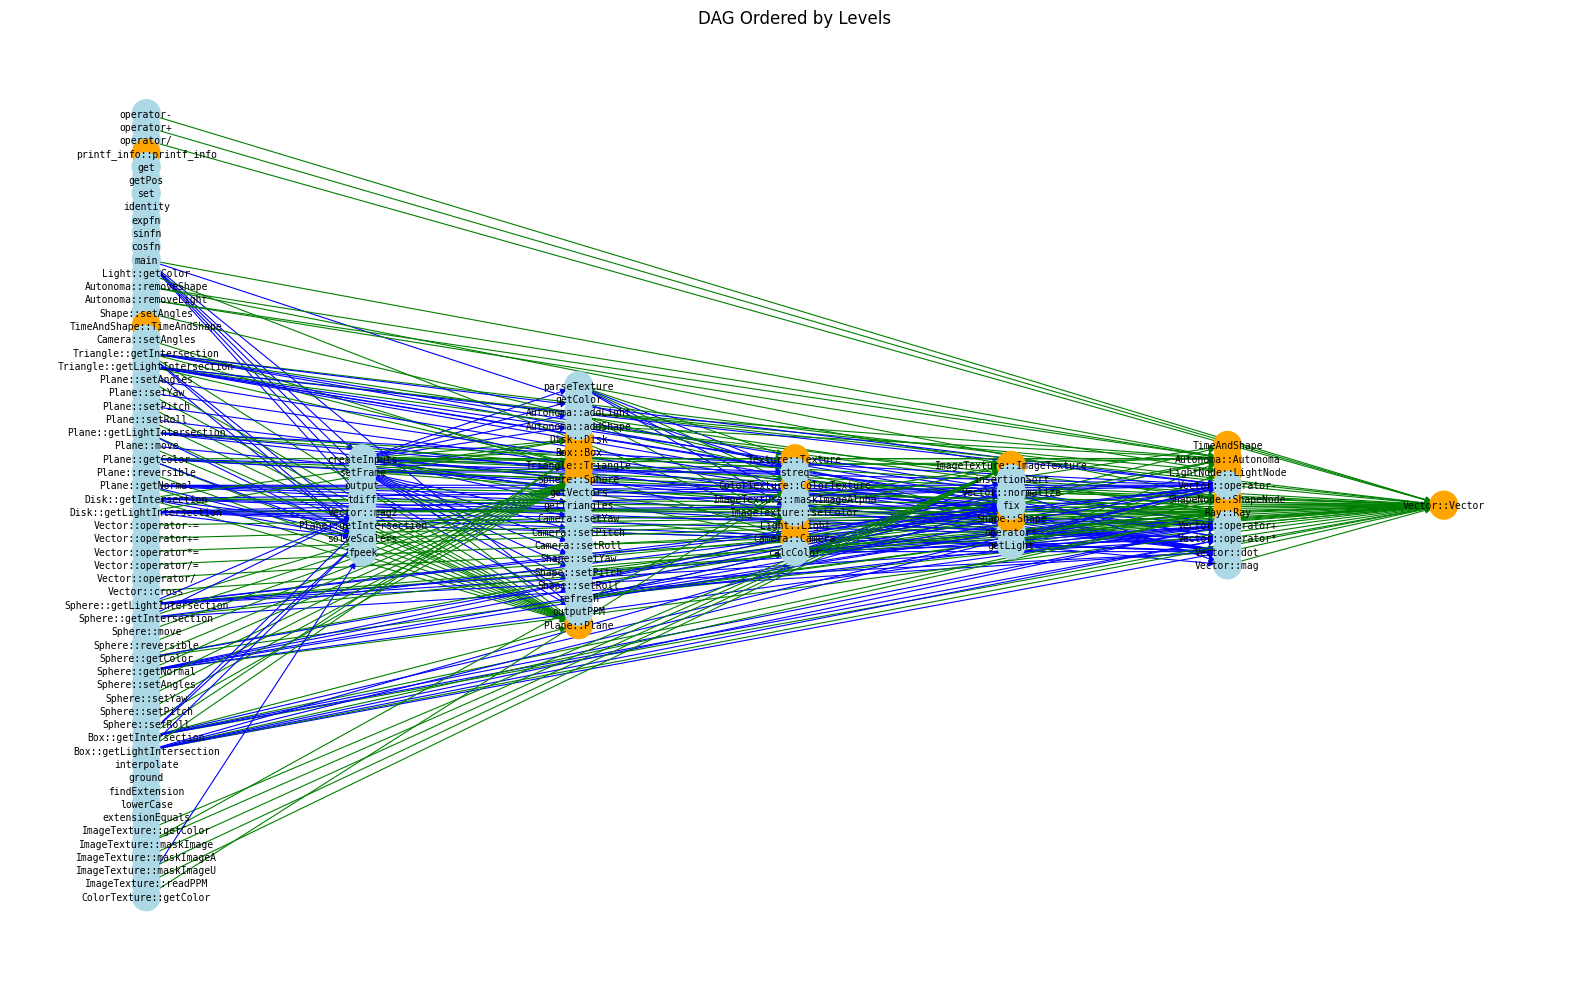

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

def plot_dag_by_levels(G, horizontal=False):
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Input graph must be a Directed Acyclic Graph (DAG)")

    # Compute node levels using topological sort
    levels = {}
    for node in nx.topological_sort(G):
        preds = list(G.predecessors(node))
        levels[node] = 0 if not preds else 1 + max(levels[p] for p in preds)

    # Group nodes by levels
    level_nodes = defaultdict(list)
    for node, lvl in levels.items():
        level_nodes[lvl].append(node)

    # Assign positions with increased spacing
    pos = {}
    max_level = max(level_nodes.keys()) if level_nodes else 0
    max_nodes_per_level = max(len(nodes) for nodes in level_nodes.values()) if level_nodes else 0
    
    # Define spacing factors
    horizontal_spacing = 2.0  # Increase for more horizontal space
    vertical_spacing = 1.5    # Increase for more vertical space
    
    for level, nodes in level_nodes.items():
        for i, node in enumerate(nodes):
            # Center nodes at each level horizontally
            offset = (max_nodes_per_level - len(nodes)) / 2
            if horizontal:
                pos[node] = (level * horizontal_spacing, -(i + offset) * vertical_spacing)
            else:
                pos[node] = ((i + offset) * horizontal_spacing, -level * vertical_spacing)

    # Define node colors based on their kind
    node_colors = []
    for node in G.nodes:
        kind = G.nodes[node].get("kind", "unknown")
        if kind == "function":
            node_colors.append("lightblue")
        elif kind == "class":
            node_colors.append("lightgreen")
        elif kind == "type":
            node_colors.append("orange")
        else:
            node_colors.append("gray")

    # Define edge colors based on their type
    edge_colors = []
    for u, v, data in G.edges(data=True):
        edge_type = data.get("type", "unknown")
        if edge_type == "call":
            edge_colors.append("blue")
        elif edge_type == "type-ref":
            edge_colors.append("green")
        else:
            edge_colors.append("gray")

    # Draw
    plt.figure(figsize=(16, 10))  # Larger figure size
    
    # Draw edges
    nx.draw_networkx_edges(
        G, pos, 
        arrowstyle='-|>', 
        arrowsize=10, 
        edge_color=edge_colors,
        width=0.8
    )
    
    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos, 
        node_size=400,  # Smaller node size
        node_color=node_colors
    )
    
    # Draw labels with smaller font
    nx.draw_networkx_labels(
        G, pos, 
        font_size=7,  # Smaller font size
        font_family='monospace'
    )
    
    plt.title("DAG Ordered by Levels")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_dag_by_levels(graph, horizontal=True)

In [ ]:
import subprocess
import json
import networkx as nx

def run_cli_and_get_successors(codebase_dir, function_name):
    try:
        result = subprocess.run(
            ["python3", "analyzers/extract_deps.py", codebase_dir, function_name],
            capture_output=True,
            text=True
        )
        output = result.stdout
        print(f"\n--- CLI output for {function_name} ---\n{output}\n")

        successors = set()
        inside_func = False

        for line in output.splitlines():
            stripped = line.strip()

            if stripped.startswith("Function:"):
                inside_func = True  # We’ve entered a new function scope
            elif stripped.startswith("Dependencies:"):
                continue
            elif "Function calls:" in stripped:
                continue
            elif stripped.startswith("- Name:"):
                name = stripped.split(":", 1)[-1].strip()
                if name:
                    successors.add(name)

        print(f"✅ Extracted from CLI ({function_name}): {successors}")
        return successors

    except Exception as e:
        print(f"⚠️ Error running CLI for {function_name}: {e}")
        return set()



def compare_graph_to_cli(graph: nx.DiGraph, codebase_dir: str):
    """
    Compare graph-based function successors to CLI tool output.
    """
    print("\n🔍 Verifying successors...")
    mismatches = []

    for node, data in graph.nodes(data=True):
        if data.get("kind") != "function":
            continue

        graph_successors = {
            succ for succ in graph.successors(node)
            if graph.nodes[succ].get("kind") == "function"
        }

        cli_successors = run_cli_and_get_successors(codebase_dir, node)

        if graph_successors != cli_successors:
            mismatches.append((node, graph_successors, cli_successors))
            print(f"\n❌ Mismatch for: {node}")
            print(f"  ➤ Graph: {sorted(graph_successors)}")
            print(f"  ➤ CLI  : {sorted(cli_successors)}")

    if not mismatches:
        print("\n✅ All function nodes match their successors!")
    else:
        print(f"\n⚠️ Found {len(mismatches)} mismatched nodes.")

    return mismatches

print(str(PROJECT_DIR))

mismatches = compare_graph_to_cli(graph, str(PROJECT_DIR))

/home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1

🔍 Verifying successors...

--- CLI output for operator- ---


✅ Extracted from CLI (operator-): set()

--- CLI output for operator+ ---


✅ Extracted from CLI (operator+): set()

--- CLI output for operator* ---


✅ Extracted from CLI (operator*): set()

--- CLI output for operator/ ---


✅ Extracted from CLI (operator/): set()

--- CLI output for tdiff ---


✅ Extracted from CLI (tdiff): set()

--- CLI output for getColor ---


✅ Extracted from CLI (getColor): set()

--- CLI output for get ---


✅ Extracted from CLI (get): set()

--- CLI output for getPos ---


✅ Extracted from CLI (getPos): set()

--- CLI output for set ---


✅ Extracted from CLI (set): set()

--- CLI output for refresh ---


✅ Extracted from CLI (refresh): set()

❌ Mismatch for: refresh
  ➤ Graph: ['Vector::operator+', 'calcColor', 'operator*']
  ➤ CLI  : []

--- CLI output for outputPPM ---


✅ Extracted from CLI (outputPPM): set()

--- CLI output for output ---



[('refresh', {'Vector::operator+', 'calcColor', 'operator*'}, set()),
 ('output', {'outputPPM'}, set()),
 ('parseTexture',
  {'ImageTexture::maskImageAlpha', 'ImageTexture::setColor', 'streq'},
  set()),
 ('createInputs',
  {'Autonoma::addLight',
   'Autonoma::addShape',
   'Vector::operator+',
   'getColor',
   'getTriangles',
   'getVectors',
   'parseTexture',
   'streq'},
  set()),
 ('setFrame',
  {'Camera::setPitch',
   'Camera::setRoll',
   'Camera::setYaw',
   'Shape::setPitch',
   'Shape::setRoll',
   'Shape::setYaw',
   'refresh',
   'streq'},
  set()),
 ('main',
  {'createInputs', 'output', 'outputPPM', 'setFrame', 'streq', 'tdiff'},
  set()),
 ('getLight',
  {'Vector::dot',
   'Vector::mag',
   'Vector::operator*',
   'Vector::operator+',
   'Vector::operator-'},
  set()),
 ('calcColor',
  {'Vector::dot',
   'Vector::normalize',
   'Vector::operator*',
   'Vector::operator+',
   'Vector::operator-',
   'fix',
   'getLight',
   'insertionSort',
   'operator*'},
  set()),
 ('T

In [ ]:
import re

print("\n--- Nodes with degree 0 --- that don't deserve it")
function_nodes = [n for n, d in graph.nodes(data=True) if d["kind"] == "function"]

whitelist = {'min', 'max', 'empty', 'size', 'full', 'pop', 'operator()', 'push'}

for n in function_nodes:
    token = n.split("::")[-1]
    if token in whitelist: continue
    if graph.degree(n) == 0:
        # get the bare function name (no namespaces)
        
        # build a regex that:
        #  - won’t match inside larger identifiers
        #  - won’t match parts of a namespace like “My::foo” inside “My::foobar”
        # (?<![\w:])  = not preceded by a word‑char or colon
        # (?![\w])    = not followed by a word‑char
        pat = re.compile(r"(?<![\w:])" + re.escape(token) + r"(?![\w])")
        
        for m in function_nodes:
            if m == n:
                continue

            code = graph.nodes[m]["code"]
            for match in pat.finditer(code):
                print("=========")
                print(f"Node {n} is referenced in {m}:")
                # location info
                loc_n = graph.nodes[n]
                loc_m = graph.nodes[m]
                print(f"  {n} defined at {loc_n['file']}:{loc_n['line']}")
                print(f"  {m} defined at {loc_m['file']}:{loc_m['line']}")
                
                # show the snippet around the match
                start, end = match.span()
                snippet = code[max(0, start-30):min(len(code), end+30)]
                # highlight the match with brackets
                highlighted = snippet.replace(
                    snippet[start - max(0, start-30): end - max(0, start-30)],
                    f"[{token}]"
                )
                print("  code context:", highlighted)
                
                # optionally print full code+AST if you still need it
                print(graph.nodes[m]['code'])
                print("==========\n")
                # once we’ve found one match, we can stop scanning this m
                break



--- Nodes with degree 0 --- that don't deserve it
Node identity is referenced in setFrame:
  identity defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/main.cpp:339
  setFrame defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/main.cpp:352
  code context: inear")) {
            func = [identity];
         } else if (streq(tr
void setFrame(const char* animateFile, Autonoma* MAIN_DATA, int frame, int frameLen) {
   if (animateFile) {
      char object_type[80];
      char transition_type[80];
      int obj_num;
      char field_type[80];
      double from;
      double to;
      FILE* f = fopen(animateFile, "r");
      while (lscanf(f, "%s %s %d %s %lf %lf", transition_type, object_type, &obj_num, field_type, &from, &to) != EOF) {
         double (*func)(double, double, double);
         if (streq(transition_type, "linear")) {
            func = identity;
         } else if (streq(transition_type, "exp")) {
            func = expfn;
         } else if (streq(trans

## Obfuscation

In [17]:
import hashlib
import os
import re
from pathlib import Path
from typing import Dict, Set, List

from clang import cindex
from clang.cindex import CursorKind

from utils.string_utils import remove_comments


class Obfuscator:
    _word_pat_cache: Dict[frozenset, re.Pattern] = {}

    _CURSOR_KINDS_BY_TIER: Dict[int, Set[CursorKind]] = {
        2: {  # Variable names (user-defined)
            CursorKind.VAR_DECL,
            CursorKind.PARM_DECL,
            CursorKind.FIELD_DECL,
        },
        3: {  # Add user-defined functions & class names
            CursorKind.FUNCTION_DECL,
            CursorKind.CXX_METHOD,
            CursorKind.FUNCTION_TEMPLATE,
            CursorKind.STRUCT_DECL,
            CursorKind.CLASS_DECL,
            CursorKind.CLASS_TEMPLATE,
        },
        4: set()  # Same as tier 3, but allows library symbols
    }

    def __init__(self, tier: int, nodes: List[dict], project_root: Path, prefix: str = "o_"):
        if not (0 <= tier <= 4):
            raise ValueError("tier must be between 0 and 4")
        self.tier = tier
        self.prefix = prefix
        self.project_root = project_root.resolve()

        self._kinds = self._resolve_kinds()
        self._tokens = self._collect_tokens(nodes)
        self._obf_map = self._create_obf_map(self._tokens)
        self._pattern = self._compiled_word_pattern(self._tokens)

    def obfuscate(self, code: str) -> str:
        if not self._obf_map:
            return code
        if self.strip_comments:
            code = remove_comments(code)

        def repl(match: re.Match[str]) -> str:
            return self._obf_map[match.group(0)]

        return self._pattern.sub(repl, code)

    def deobfuscate(self, code: str) -> str:
        if not self._obf_map:
            return code
        reverse_map = {v: k for k, v in self._obf_map.items()}
        pattern = self._compiled_word_pattern(set(reverse_map))

        def repl(match: re.Match[str]) -> str:
            return reverse_map[match.group(0)]

        return pattern.sub(repl, code)

    @property
    def obfuscation_map(self) -> Dict[str, str]:
        return self._obf_map

    @property
    def strip_comments(self) -> bool:
        return self.tier >= 1

    def _resolve_kinds(self) -> Set[cindex.CursorKind]:
        if self.tier < 2:
            return set()
        kinds = set()
        for t in range(2, self.tier + 1):
            kinds.update(self._CURSOR_KINDS_BY_TIER.get(t, set()))
        return kinds

    def _collect_tokens(self, nodes: List[dict]) -> Set[str]:
        tokens = set()

        def _should_obfuscate(cur: cindex.Cursor) -> bool:
            if cur is None or cur.kind == CursorKind.TRANSLATION_UNIT:
                return False
            if cur.kind not in self._kinds:
                return False
            if self.tier >= 4:
                return True
            return self._is_user_defined(cur)

        def _recurse(cur: cindex.Cursor):
            if _should_obfuscate(cur) and cur.spelling:
                tokens.add(cur.spelling)
            for child in cur.get_children():
                _recurse(child)

        for node in nodes:
            cursor = node.get("cursor")
            if cursor:
                _recurse(cursor)

        return tokens

    def _create_obf_map(self, tokens: Set[str]) -> Dict[str, str]:
        return {
            token: f"{self.prefix}{hashlib.sha1(token.encode()).hexdigest()[:8]}"
            for token in sorted(tokens)
        }

    def _compiled_word_pattern(self, words: Set[str]) -> re.Pattern:
        key = frozenset(words)
        if key in self._word_pat_cache:
            return self._word_pat_cache[key]
        altern = "|".join(map(re.escape, sorted(words, key=len, reverse=True)))
        pat = re.compile(rf"(?<!\w)(?:{altern})(?!\w)")
        self._word_pat_cache[key] = pat
        return pat

    def _is_user_defined(self, cursor: cindex.Cursor) -> bool:
        definition = cursor.get_definition()
        loc_file = (
            definition.location.file.name
            if definition and definition.location.file
            else cursor.location.file.name
            if cursor.location.file
            else None
        )
        if loc_file is None:
            return self.tier >= 4

        file_path = Path(loc_file).resolve()
        try:
            in_project = file_path.is_relative_to(self.project_root)
        except AttributeError:
            in_project = str(file_path).startswith(str(self.project_root))

        is_writeable = os.access(file_path, os.W_OK)
        return in_project or is_writeable or self.tier >= 4


import random
import textwrap

random_node = random.choice(list(graph.nodes))
successors = list(graph.successors(random_node))
nodes = [graph.nodes[n] for n in successors]
nodes.append(graph.nodes[random_node])

obfuscator = Obfuscator(tier=3, nodes=nodes, project_root=PROJECT_DIR)

code = "\n".join(n["code"] for n in nodes)

obfuscated_code = obfuscator.obfuscate(code)
deobfuscated_code = obfuscator.deobfuscate(obfuscated_code)

print("\nOriginal code:")
print(textwrap.indent(code, "  "))

print("\nObfuscated code:")
print(textwrap.indent(obfuscated_code, "  "))

print("\nDeobfuscated code:")
print(textwrap.indent(deobfuscated_code, "  "))

print("\nObfuscation map:")
for orig, obf in obfuscator.obfuscation_map.items():
    print(f"  {orig} -> {obf}")

if remove_comments(deobfuscated_code) == remove_comments(code):
    print("\n✅ Deobfuscation successful!")
else:
    print("\n❌ Deobfuscation failed.")



Original code:
  template <typename math_t = float>
  void meanSquareError(const uint64_t n_samples, const uint64_t n_progs,
                       const math_t *Y, const math_t *Y_pred, const math_t *W,
                       math_t *out) {

    std::vector<math_t> error(n_samples * n_progs);
    math_t N = static_cast<math_t>(n_samples);

    // Weight Sum
    math_t WS = static_cast<math_t>(0);
    for (uint64_t i = 0; i < n_samples; ++i) {
      WS += W[i];
    }

    // Compute absolute differences
    for (uint64_t pid = 0; pid < n_progs; ++pid) {
      for (uint64_t i = 0; i < n_samples; ++i) {
        error[pid * n_samples + i] = N * W[i] *
                                     (Y_pred[pid * n_samples + i] - Y[i]) *
                                     (Y_pred[pid * n_samples + i] - Y[i]) / WS;
      }
    }

    // Average along rows
    for (uint64_t pid = 0; pid < n_progs; ++pid) {
      out[pid] = static_cast<math_t>(0);
      for (uint64_t i = 0; i < n_samples; ++i) {
    

## Optimization

In [ ]:
from typing import Optional, List, Dict
import openai
import anthropic
from collections import deque
from utils.string_utils import extract_markdown_blocks, markdown_to_dict

class OptimizerAgent:
    def __init__(self, model: str, provider: str = "openai", api_key: Optional[str] = None):
        self.model = model
        self.provider = provider
        self.api_key = api_key

        # Simulate backend client (replace with real SDKs)
        if provider == "openai":
            self.client = openai.OpenAI(api_key=api_key)
        elif provider == "anthropic":
            self.client = anthropic.Anthropic(api_key=api_key)
        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def prompt(self,
               input_prompt: str,
               context_window: Optional[List[str]] = None,
               system_message: Optional[str] = "You are an expert C++ performance optimization engineer.",
               temperature: float = 0.7,
               max_tokens: int = 4096) -> str:
        messages = []
        if system_message:
            messages.append({"role": "system", "content": system_message})
        if context_window:
            messages.extend({"role": "user", "content": m} for m in context_window)
        messages.append({"role": "user", "content": input_prompt})

        if self.provider == "openai":
            response = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens
            )
            return response.choices[0].message.content

        elif self.provider == "anthropic":
            messages = []
            if system_message:
                messages.append({"role": "system", "content": system_message})
            if context_window:
                messages.extend({"role": "user", "content": m} for m in context_window)
            messages.append({"role": "user", "content": input_prompt})

            response = self.client.messages.create(
                model=self.model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens
            )
            return response.content[0].text


    def optimize_node(self,
                    node: str,
                    obfuscation_tier: int = 0,
                    context_window: Optional[List[str]] = None,
                    system_message: Optional[str] = None,
                    context_depth: int = 0,
                    response_format: Optional[str] = None) -> None:
        """
        Optimize a code node from a graph.
        """
        labels = graph.nodes[node]
        code = labels.get("code", "").strip()
        if not code:
            raise ValueError("Node has no code")

        if obfuscator:
            code = obfuscator.obfuscate(code)

        file_path = labels.get("file", "<unknown file>")

        
        # get all nodes within 3 hops of the current node from the graph
        context_nodes = list(nx.single_source_shortest_path_length(graph, node, cutoff=context_depth).keys())
        obfuscator = Obfuscator(
            tier=obfuscation_tier,
            nodes=[graph.nodes[n] for n in context_nodes],
            project_root=PROJECT_DIR
        )
        additional_context = []
        for n in context_nodes:
            if n == node:
                continue
            context_node = graph.nodes[n]
            context_code = context_node.get("code", "").strip()
            if context_code:
                context_code = obfuscator.obfuscate(context_code) if obfuscator else context_code
                additional_context.append(f"File: {context_node['file']}\n```cpp\n{context_code}\n```")

        if context_window is None:
            context_window = []
        context_window.extend(additional_context)

        prompt = (
            f"Optimize the following function {node} for performance. "
            "Only modify the internals, and keep the function name and signature the same.\n"
            f"\n```cpp\n{code}\n```"
            # If there is a response format specified, include it in the prompt
            + (f"\n\nResponse format:\n{response_format}" if response_format else "")
        )

        response = self.prompt(input_prompt=prompt, context_window=context_window, system_message=system_message)

        if obfuscator:
            response = obfuscator.deobfuscate(response)
        return response
        

# Example usage
optimizer = OptimizerAgent(model="claude-3-opus-20240229", provider="anthropic", api_key=os.getenv("ANTHROPIC_API_KEY"))
print(optimizer.optimize_node(node=random_node, context_depth=1))


Here's an optimized version of the `meanSquareError` function:

```cpp
template <typename math_t = float>
void meanSquareError(const uint64_t n_samples, const uint64_t n_progs,
                     const math_t *Y, const math_t *Y_pred, const math_t *W,
                     math_t *out) {
  const math_t N = static_cast<math_t>(n_samples);

  // Compute weight sum
  math_t WS = static_cast<math_t>(0);
  for (uint64_t i = 0; i < n_samples; ++i) {
    WS += W[i];
  }

  // Compute mean square error for each program
  for (uint64_t pid = 0; pid < n_progs; ++pid) {
    math_t sum = static_cast<math_t>(0);
    const math_t *Y_pred_ptr = Y_pred + pid * n_samples;
    for (uint64_t i = 0; i < n_samples; ++i) {
      const math_t diff = Y_pred_ptr[i] - Y[i];
      sum += W[i] * diff * diff;
    }
    out[pid] = N * sum / WS / N;
  }
}
```

Here are the main optimizations made:

1. Removed the `error` vector and directly accumulated the sum of squared differences for each program in the `sum` va